[競賽連結](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview)

In [ ]:
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import LabelEncoder
from itertools import product
import gc
#import lightgbm as lgb
import time
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from numpy import sqrt
warnings.filterwarnings(action='ignore') # Ignore warning message

path='data/'

items = pd.read_csv(path+'/items.csv')
item_categories = pd.read_csv(path+'/item_categories.csv')
shops = pd.read_csv(path+'/shops.csv')
sales_train = pd.read_csv(path+'/sales_train.csv')
test = pd.read_csv(path+'/test.csv')
submission = pd.read_csv(path+'/sample_submission.csv')

print("Data set loaded successfully.")

Data set loaded successfully.


## 壓縮檔案

In [ ]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

62.5% compressed
38.6% compressed
54.2% compressed
39.9% compressed
70.8% compressed


## 去除離群值 和 觀察某商店名稱有重複

In [ ]:
# Extract data with a item_price greater than 0
sales_train = sales_train[sales_train['item_price'] > 0]
# Extract data with a item_priceof less than 50,000
sales_train = sales_train[sales_train['item_price'] < 50000]
# Extract data with item_cnt_day greater than 0
sales_train = sales_train[sales_train['item_cnt_day'] > 0]
# Extract data with item_cnt_day less than 1,000
sales_train = sales_train[sales_train['item_cnt_day'] < 1000]

print(shops['shop_name'][0], '||', shops['shop_name'][57])
print(shops['shop_name'][1], '||', shops['shop_name'][58])
print(shops['shop_name'][10], '||', shops['shop_name'][11])
print(shops['shop_name'][39], '||', shops['shop_name'][40])

!Якутск Орджоникидзе, 56 фран || Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран || Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м? || Жуковский ул. Чкалова 39м²
РостовНаДону ТРК "Мегацентр Горизонт" || РостовНаДону ТРК "Мегацентр Горизонт" Островной


In [ ]:
#  Modify shop_id in sales_train data
sales_train.loc[sales_train['shop_id'] == 0, 'shop_id'] = 57
sales_train.loc[sales_train['shop_id'] == 1, 'shop_id'] = 58
sales_train.loc[sales_train['shop_id'] == 10, 'shop_id'] = 11
sales_train.loc[sales_train['shop_id'] == 39, 'shop_id'] = 40

#  Modify shop_id in test data
test.loc[test['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 39, 'shop_id'] = 40

# 確保test 和 train 資料有重和
unique_test_shop_id = test['shop_id'].unique()
sales_train = sales_train[sales_train['shop_id'].isin(unique_test_shop_id)]

## 把商店名稱的頭一個字取出 為新的欄位 並做編碼

In [ ]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0])
shops.loc[shops['city'] =='!Якутск', 'city'] = 'Якутск'

# Create Label Encoder
label_encoder = LabelEncoder()
# City Feature Label Encoding 
shops['city'] = label_encoder.fit_transform(shops['city'])
# Remove shop_name feature
shops = shops.drop('shop_name', axis=1)

In [ ]:
# Remove item_name feature
items = items.drop(['item_name'], axis=1)
# Create the date the product was first sold as a feature
items['first_sale_date'] = sales_train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']

items.head()

,item_id,item_category_id,first_sale_date
0,0,40,NaN
1,1,76,15.0
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN


In [ ]:
# Replace NaN of first_sale_date with 34
items['first_sale_date'] = items['first_sale_date'].fillna(34)

## 同商店名稱的原理

In [ ]:
# Extract the first word of the item_categories_name into category
item_categories['category'] = item_categories['item_category_name'].apply(lambda x: x.split()[0]) 

def make_etc(x):
    if len(item_categories[item_categories['category']==x]) >= 5:
        return x
    else:
        return 'etc'

# Replace with 'etc' if category count is less than 5
item_categories['category'] = item_categories['category'].apply(make_etc)
item_categories.head()

,item_category_name,item_category_id,category
0,PC - Гарнитуры/Наушники,0,etc
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


In [ ]:
# Create Label Encoder
label_encoder = LabelEncoder()
# Category Feature Label Encoding 
item_categories['category'] = label_encoder.fit_transform(item_categories['category'])

# Remove item_category_name feature
item_categories = item_categories.drop('item_category_name', axis=1)

In [ ]:
from itertools import product

train = []
# 利用迴圈排完後表格按照月份0-34排列
for i in sales_train['date_block_num'].unique():
    all_shop = sales_train.loc[sales_train['date_block_num']==i, 'shop_id'].unique()
    all_item = sales_train.loc[sales_train['date_block_num']==i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features
train = pd.DataFrame(np.vstack(train), columns=idx_features)

group = sales_train.groupby(idx_features).agg({'item_cnt_day': 'sum',
                                               'item_price': 'mean'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_cnt_month', 'item_price': 'item_price_mean'})

train = train.merge(group, on=idx_features, how='left')

train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean
0,0,59,22154,1.0,999.0
1,0,59,2552,NaN,NaN
2,0,59,2554,NaN,NaN
3,0,59,2555,NaN,NaN
4,0,59,2564,NaN,NaN


In [ ]:

# group variable garbage collection
del group
gc.collect();

In [ ]:
# Add a feature for the number of items sold
group = sales_train.groupby(idx_features).agg({'item_cnt_day': 'count'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_count'})

train = train.merge(group, on=idx_features, how='left')

# Garbage collection
del group, sales_train
gc.collect()

train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,NaN,NaN,NaN
2,0,59,2554,NaN,NaN,NaN
3,0,59,2555,NaN,NaN,NaN
4,0,59,2564,NaN,NaN,NaN


## 新增test的欄位['date_block_num'] 為34

In [ ]:

test['date_block_num'] = 34

# 合併 train test
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# Replace NaN with 0
all_data = all_data.fillna(0)

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0


## 原本train 的 item_cnt_day 變 item_cnt_month，item_price變成平均值

In [ ]:
# Merge other data
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(items, on='item_id', how='left')
all_data = all_data.merge(item_categories, on='item_category_id', how='left')

# Data downcasting
all_data = downcast(all_data)

# Garbage collection
del shops, items, item_categories
gc.collect();

64.6% compressed


In [ ]:
all_data_not = all_data.copy()
all_data_not.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8856961 entries, 0 to 8856960
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int8   
 1   shop_id           int8   
 2   item_id           int16  
 3   item_cnt_month    int16  
 4   item_price_mean   float32
 5   item_count        int8   
 6   city              int8   
 7   item_category_id  int8   
 8   first_sale_date   int8   
 9   category          int8   
dtypes: float32(1), int16(2), int8(7)
memory usage: 194.3 MB


## 從這裡開始選做 主要就是增加更多欄位 平均值和lag freature 連結為介紹時間序列的特徵工程
https://medium.com/@folderplus/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92%E7%9A%84%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97%E7%89%B9%E5%BE%B5%E5%B7%A5%E7%A8%8B-8ec54cd6b93f

In [ ]:
def add_mean_features(df, mean_features, idx_features):
    # Check base features
    assert (idx_features[0] == 'date_block_num') and \
           len(idx_features) in [2, 3]
    
    # Set derived feature name 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '_mean_sales'
    else:
        feature_name = idx_features[1] + '_' + idx_features[2] + '_mean_sales'
    
    # Get average monthly sales by grouping based on base features
    group = df.groupby(idx_features).agg({'item_cnt_month': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_cnt_month': feature_name})
    
    # Merge df with group based on idx_features
    df = df.merge(group, on=idx_features, how='left')
    # Date downcasting
    df = downcast(df, False)
    # Append newly created mean_feature_name features to the mean_features list
    mean_features.append(feature_name)
    
    # Garbage collection
    del group
    gc.collect()
    
    return df, mean_features

In [ ]:
# List of derived features containing 'item_id' in the grouping base features
item_mean_features = []


# Create monthly average sales derived features grouped by ['date_block_num', 'item_id']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id'])

# Create monthly average sales derived features grouped by ['date_block_num', 'item_id', 'city']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id', 'city'])
item_mean_features

['item_id_mean_sales', 'item_id_city_mean_sales']

In [ ]:
# List of derived features containing 'shop_id' in the grouping base features
shop_mean_features = []

# Create monthly average sales derived features grouped by ['date_block_num', 'shop_id', 'item_category_id']
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['date_block_num', 'shop_id', 'item_category_id'])
shop_mean_features

['shop_id_item_category_id_mean_sales']

In [ ]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    # Copy only the part of the DataFrame needed to create the lag features
    df_temp = df[idx_features + [lag_feature]].copy() 

    # Create lag features
    for i in range(1, nlags+1):
        # Lag featrue name
        lag_feature_name = lag_feature +'_lag' + str(i)
        # Set df_temp column name
        df_temp.columns = idx_features + [lag_feature_name]
        # Add 1 to date_block_num feature in df_temp
        df_temp['date_block_num'] += i
        # Merge df with df_temp based on idx_feature
        df = df.merge(df_temp.drop_duplicates(), 
                      on=idx_features, 
                      how='left')
        # Replace NaN with 0
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        # Add lag features to lag_features_to_clip to clip between 0 and 20
        if clip: 
            lag_features_to_clip.append(lag_feature_name)
    
    # Date downcasting
    df = downcast(df, False)
    # Garbage collection
    del df_temp
    gc.collect()
    
    return df, lag_features_to_clip

In [ ]:
lag_features_to_clip = [] # list of lag features to be clipped to between 0 to 20 
idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features

# Create 3 month lag features of item_cnt_month based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_cnt_month', 
                                                  nlags=3,
                                                  clip=True)
all_data.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,59.000000,59.000000,59.000000,59.000000,59.000000
item_id,22154.000000,2552.000000,2554.000000,2555.000000,2564.000000
item_cnt_month,1.000000,0.000000,0.000000,0.000000,0.000000
item_price_mean,999.000000,0.000000,0.000000,0.000000,0.000000
item_count,1.000000,0.000000,0.000000,0.000000,0.000000
city,30.000000,30.000000,30.000000,30.000000,30.000000
item_category_id,37.000000,58.000000,58.000000,56.000000,59.000000
first_sale_date,0.000000,0.000000,0.000000,0.000000,0.000000
category,5.000000,7.000000,7.000000,7.000000,7.000000


In [ ]:
lag_features_to_clip

['item_cnt_month_lag1', 'item_cnt_month_lag2', 'item_cnt_month_lag3']

In [ ]:
# Create 3 month lag features of item_count feature based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_count', 
                                                  nlags=3)

# Create 3 month lag features of item_price_mean feature based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_price_mean', 
                                                  nlags=3)

In [ ]:
# Create lag features by item_mean_features element based on dx_features
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3)
# Remove features in item_mean_features
all_data = all_data.drop(item_mean_features, axis=1)

In [ ]:
# Create lag features by shop_mean_features element based on ['date_block_num', 'shop_id', 'item_category_id']
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=['date_block_num', 'shop_id', 'item_category_id'], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3)
# Remove features in shop_mean_features
all_data = all_data.drop(shop_mean_features, axis=1)

In [ ]:
# Remove data less than date ID 3
all_data = all_data.drop(all_data[all_data['date_block_num'] < 3].index)

In [ ]:
all_data['item_cnt_month_lag_mean'] = all_data[['item_cnt_month_lag1',
                                         'item_cnt_month_lag2', 
                                         'item_cnt_month_lag3']].mean(axis=1)
# Clip 0~20
all_data[lag_features_to_clip + ['item_cnt_month', 'item_cnt_month_lag_mean']] = all_data[lag_features_to_clip +['item_cnt_month', 'item_cnt_month_lag_mean']].clip(0, 20)

all_data['lag_grad1'] = all_data['item_cnt_month_lag1']/all_data['item_cnt_month_lag2']
all_data['lag_grad1'] = all_data['lag_grad1'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

all_data['lag_grad2'] = all_data['item_cnt_month_lag2']/all_data['item_cnt_month_lag3']
all_data['lag_grad2'] = all_data['lag_grad2'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

In [ ]:
all_data['brand_new'] = all_data['first_sale_date'] == all_data['date_block_num']
all_data['brand_new']

827196     False
827197     False
827198     False
827199     False
827200     False
           ...  
8856956    False
8856957    False
8856958    False
8856959    False
8856960    False
Name: brand_new, Length: 8029765, dtype: bool

In [ ]:
all_data['duration_after_first_sale'] = all_data['date_block_num'] - all_data['first_sale_date']
all_data = all_data.drop('first_sale_date', axis=1)
all_data['month'] = all_data['date_block_num']%12

In [ ]:
# Remove item_price_mean, item_count features
all_data = all_data.drop(['item_price_mean', 'item_count'], axis=1)
all_data = downcast(all_data, False) # Data downcasting
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8029765 entries, 827196 to 8856960
Data columns (total 31 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   date_block_num                            int8   
 1   shop_id                                   int8   
 2   item_id                                   int16  
 3   item_cnt_month                            int8   
 4   city                                      int8   
 5   item_category_id                          int8   
 6   category                                  int8   
 7   item_cnt_month_lag1                       int8   
 8   item_cnt_month_lag2                       int8   
 9   item_cnt_month_lag3                       int8   
 10  item_count_lag1                           int8   
 11  item_count_lag2                           int8   
 12  item_count_lag3                           int8   
 13  item_price_mean_lag1                      float32
 1

In [ ]:
all_data = all_data.drop(["month", "duration_after_first_sale", "brand_new", "lag_grad2", "lag_grad1"], axis=1)

## 開始執行 下面切割 train test valid

In [ ]:
# Train data (Features)
X_train_not = all_data_not[all_data_not['date_block_num'] < 33]
X_train_not = X_train_not.drop(['item_cnt_month'], axis=1)
# Valid data (Features)
X_valid_not = all_data_not[all_data_not['date_block_num'] == 33]
X_valid_not = X_valid_not.drop(['item_cnt_month'], axis=1)
# Test data (Features)
X_test_not = all_data_not[all_data_not['date_block_num'] == 34]
X_test_not = X_test_not.drop(['item_cnt_month'], axis=1)

# Train data (Target values)
y_train_not = all_data_not[all_data_not['date_block_num'] < 33]['item_cnt_month']
# Valid data (Target values)
y_valid_not = all_data_not[all_data_not['date_block_num'] == 33]['item_cnt_month']

# Garbage collection
del all_data_not
gc.collect();

In [ ]:
# Train data (Features)
X_train = all_data[all_data['date_block_num'] < 33]
#X_train = all_data.query('date_block_num > 16 and date_block_num < 33')
X_train = X_train.drop(['item_cnt_month'], axis=1)
# Valid data (Features)
X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_month'], axis=1)
# Test data (Features)
X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_month'], axis=1)

# Train data (Target values)
y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
# Valid data (Target values)
y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

# Garbage collection
#del all_data
#gc.collect();

In [ ]:
print('X_train.shape=',X_train.shape,' y_train.shape=',y_train.shape)
print('X_test.shape=',X_valid.shape,' y_test.shape=',y_valid.shape)
print("----------------------------------------------------------------------")
#print('X_train.shape=',X_train_not.shape,' y_train.shape=',y_train_not.shape)
#print('X_test.shape=',X_valid_not.shape,' y_test.shape=',y_valid_not.shape)

X_train.shape= (7593847, 30)  y_train.shape= (7593847,)
X_test.shape= (221718, 30)  y_test.shape= (221718,)
----------------------------------------------------------------------


## 調整最佳參數 如果中間一段跳過的話 參數要用 X_train_not

In [ ]:
def get_best_parameter(model, params, X, y, best=False):
    if best:
        grid = GridSearchCV(model, params, cv=3, verbose=1, scoring="neg_root_mean_squared_error", n_jobs=-1)  
        grid.fit(X, y)
        print(f"Best accuracy: {grid.best_score_}")
        print(f"Best parameters: {grid.best_params_}")
        print(f"Average time(s) to fit: {round(grid.cv_results_['mean_fit_time'].mean(), 3)}")
        print(f"Average time(s) to score: {round(grid.cv_results_['mean_score_time'].mean(), 3)}")
        return grid, best
    else:
        grid = model.fit(X, y)
        return grid, best        

# XGB

In [ ]:
'''xgb_param_grid = {
    'n_estimators':range(80,200,4), # 樹有幾棵
    'max_depth':range(2,15,1), # 樹的深度
    'learning_rate':np.linspace(0.01,0.08,20),
    'colsample_bytree':np.linspace(0.5,0.98,10),
    'min_child_weight':range(1,9,1),
    'subsample':np.linspace(0.7,0.9,20)
    }'''
xgb_param_grid = {'n_estimators': [400, 500, 600, 700, 800]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
xgb = XGBRegressor(**other_params)
start = time.time()
xgb_best, best = get_best_parameter(xgb, xgb_param_grid, X_train, y_train)#如果要調整 多加一個 True: get_best_parameter(xgb, xgb_param_grid, X_train, y_train, True)
end = time.time()
print("執行時間：%f 分鐘" % ((end - start)/60)) #48分鐘

[14:34:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:36] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
執行時間：2630.372626 秒


In [ ]:

preds = xgb_best.predict(X_valid)
rmse = sqrt(mean_squared_error(y_valid,preds))
if best:
    print('RMSE: %.3f for adjusted_xgb' % rmse)
else:
    print('RMSE: %.3f for xgboost' % rmse)

RMSE: 0.825


# LIGHT GBM

In [ ]:
#other_params_lgb = {'learning_rate': 0.01, 'n_estimators': 500}
                
param_grid= {
              #'max_depth': [10, 15, 20],
              'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.5],
              'n_estimators': [100, 300, 500, 700, 900]
              #'reg_alpha': [0.25, 0.5, 0.75],
              #'reg_lambda': [0.4, 0.6, 0.8]
}
estimator = LGBMRegressor()
start = time.time()
gbm_best, best = get_best_parameter(estimator, param_grid, X_train_not, y_train_not, True)
end = time.time()
print("執行時間：%f 分鐘" % ((end - start)/60))

執行時間：6.886923 分鐘


In [ ]:
preds_g = gbm_best.predict(X_valid)
rmse_g = sqrt(mean_squared_error(y_valid,preds_g))
if best:
    print('RMSE: %.3f for adjusted_light_gbm' % rmse_g)
else:
    print('RMSE: %.3f for light_gbm' % rmse_g)

RMSE: 0.813 for light_gbm


In [ ]:
dfResults=pd.DataFrame(gbm_best.cv_results_)
scores=np.array(dfResults.mean_test_score).reshape(5,5)

In [ ]:
import mglearn
mglearn.tools.heatmap(scores, xlabel='learning_rate', xticklabels=param_grid['learning_rate'],
                     ylabel='n_estimators',yticklabels=param_grid['n_estimators'],cmap="viridis")

# 深度學習

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model

In [ ]:
X_train_r = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_r = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_r = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_train_r.shape)
print(X_valid_r.shape) 
print(X_test_r.shape)

(7593847, 30, 1)
(221718, 30, 1)
(214200, 30, 1)


In [ ]:
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath='model03.h5',
    monitor='val_loss',
    save_best_only=True), tf.keras.callbacks.EarlyStopping(patience=3, monitor = 'val_loss')]

In [ ]:
serie_size =  X_train_r.shape[1] 
n_features =  X_train_r.shape[2] 

epochs = 10
batch = 128
lr = 0.0001

lstm_model = Sequential()
lstm_model.add(L.LSTM(16, input_shape=(serie_size, n_features), return_sequences=True))
lstm_model.add(L.Dropout(0.2))
lstm_model.add(L.LSTM(10, activation='tanh', return_sequences=True))
lstm_model.add(L.Dropout(0.2))
lstm_model.add(L.LSTM(1, activation='tanh'))
lstm_model.add(L.Dropout(0.2))
lstm_model.add(L.Dense(256, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(128, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(1))
lstm_model.summary()

adam = optimizers.Adam(lr)
lstm_model.compile(loss='mse', optimizer=adam)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 16)            1152      
_________________________________________________________________
dropout (Dropout)            (None, 30, 16)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 10)            1080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 10)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1)                 48        
_________________________________________________________________
dropout_2 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense (Dense)                (None, 256)               5

In [ ]:
# 需要的話可以載入
lstm_model.load_weights("model03.h5")

In [ ]:
lstm_history = lstm_model.fit(X_train_r, y_train, 
                              validation_data=(X_valid_r, y_valid), 
                              batch_size=128, 
                              epochs=10, 
                              verbose=2,
                              callbacks=[model_checkpoint_callback])

Epoch 1/10
59327/59327 - 425s - loss: 1.1103 - val_loss: 0.7811
Epoch 2/10
59327/59327 - 413s - loss: 1.0413 - val_loss: 0.7349
Epoch 3/10
59327/59327 - 413s - loss: 1.0114 - val_loss: 0.7091
Epoch 4/10
59327/59327 - 413s - loss: 1.0009 - val_loss: 0.7010
Epoch 5/10
59327/59327 - 410s - loss: 0.9918 - val_loss: 0.6931
Epoch 6/10
59327/59327 - 404s - loss: 0.9892 - val_loss: 0.6909
Epoch 7/10
59327/59327 - 404s - loss: 0.9833 - val_loss: 0.6930
Epoch 8/10
59327/59327 - 404s - loss: 0.9782 - val_loss: 0.7049
Epoch 9/10
59327/59327 - 402s - loss: 0.9773 - val_loss: 0.6982


In [ ]:
lstm_model.save("final_model.h5")
lstm_model.save_weights("model_weights.h5")

In [ ]:
train_loss = lstm_history.history["loss"]
valid_loss = lstm_history.history["val_loss"]

In [ ]:
preds = lstm_model.predict(X_test_r).clip(0,20)

submission['item_cnt_month'] = preds
submission.to_csv('submissionLSTM03.csv', index=False)

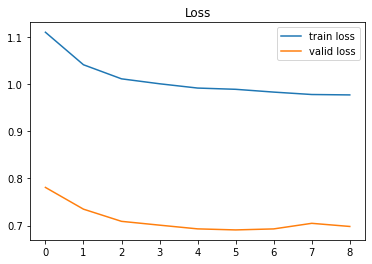

In [ ]:
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

# 網路上調好的參數

In [ ]:
import lightgbm as lgb

# lgb hyper-parameters
params = {'metric': 'rmse',
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise' : True,
          'random_state': 10}

cat_features = ['shop_id', 'city', 'item_category_id', 'category', 'month']

# lgb train and valid dataset
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
start = time.time()
# Train LightGBM model
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=cat_features,
                      verbose_eval=100)
end = time.time()
print("執行時間：%f 分鐘" % ((end - start)/60))
print("-----------------------------------------------------")
preds_lab = lgb_model.predict(X_valid)
rmse_lab = sqrt(mean_squared_error(y_valid,preds_lab))
print('RMSE: %.3f for adjust_gbm' % rmse_lab)


preds = lgb_model.predict(X_test).clip(0,20)

submission['item_cnt_month'] = preds
submission.to_csv('submission.csv', index=False)

Training until validation scores don't improve for 150 rounds.
[100]	training's rmse: 1.01975	valid_1's rmse: 0.914046
[200]	training's rmse: 0.915371	valid_1's rmse: 0.841346
[300]	training's rmse: 0.863001	valid_1's rmse: 0.811784
[400]	training's rmse: 0.83395	valid_1's rmse: 0.799949
[500]	training's rmse: 0.814997	valid_1's rmse: 0.794545
[600]	training's rmse: 0.801496	valid_1's rmse: 0.792696
[700]	training's rmse: 0.791432	valid_1's rmse: 0.792163
[800]	training's rmse: 0.782954	valid_1's rmse: 0.791036
[900]	training's rmse: 0.775752	valid_1's rmse: 0.79083
[1000]	training's rmse: 0.769454	valid_1's rmse: 0.790704
[1100]	training's rmse: 0.764347	valid_1's rmse: 0.790617
[1200]	training's rmse: 0.759915	valid_1's rmse: 0.790679
Early stopping, best iteration is:
[1074]	training's rmse: 0.765634	valid_1's rmse: 0.790521
執行時間：25.118407 分鐘
-----------------------------------------------------
RMSE: 0.791 for adjust_gbm
